# Fish mortality prediction using Prophet time series forecasting

The purpose here is to explore some fish mortality time series & see what predictive value we can get out of it. We will approach the problem as a time series forecasting one.

In [ ]:
! pip install numpy plotly fbprophet data_describe >/dev/null

In [ ]:
# We import important libraries

# general
import pandas as pd
import numpy as np
from datetime import datetime
# viz
import seaborn as sns
import matplotlib.pyplot as plt
import data_describe as dd
import plotly.express as px
# time series
from data_describe.core.time import plot_autocorrelation, stationarity_test
from statsmodels.tsa.seasonal import seasonal_decompose
# ts ML & prediction
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## 1. Data importation

In [ ]:
 # I stored the data online to make it available of all users of this private notebook and cloud-ready. Here's the url
url = 'https://raw.githubusercontent.com/corridordigital/ScanData/main/SERIE%20TEMP%20SCANBIO%20TEST.csv'

In [ ]:
df = pd.read_csv(url,
        sep=';',
        error_bad_lines=False,
        #index_col=["Date "],
        usecols=["Date ", "Quantity"],
        parse_dates=["Date "]
        )

df.columns

Index(['Date ', 'Quantity'], dtype='object')

## 3. Data Cleaning & pre-processing

In [ ]:
# Rename
df = df.rename(columns={"Date ": "date", "Quantity": "qty"})
df['date'] = pd.to_datetime(df['date'])
df = df.drop(df[df.date >= '2021-03-01'].index)

In [ ]:
print(df.head(), '\n')
print(df.tail(), '\n')
print(df.shape, '\n')
df.dtypes

        date     qty
0 2014-04-14    5000
1 2014-04-24    8000
2 2014-04-24    2000
3 2014-04-27  150000
4 2014-04-28    5000 

            date    qty
22802 2021-02-27  19500
22803 2021-02-27  20500
22804 2021-02-27  22500
22805 2021-02-28   4300
22806 2021-02-28  15200 

(22807, 2) 



date    datetime64[ns]
qty              int64
dtype: object

In [ ]:
# Let's group by day
df_grouped = pd.DataFrame(df.groupby("date")["qty"].sum())
df_grouped.shape

(2480, 1)

In [ ]:
# Deleting outliers
df_grouped = df_grouped.drop(df_grouped[df_grouped.qty > 800000].index)

In [ ]:
# We group by week
df_clean = df_grouped.resample('W').sum()
df_grouped.shape

(2468, 1)

In [ ]:
fig = px.line(df_clean, y="qty")
fig.show()

In [ ]:
df_clean.describe()

,qty
count,3.590000e+02
mean,1.189901e+06
std,3.953001e+05
min,5.000000e+03
25%,9.539410e+05
50%,1.203900e+06
75%,1.459530e+06
max,2.235300e+06


## 2. Data Exploration

In [ ]:
df_clean.describe()

,qty
count,3.590000e+02
mean,1.189901e+06
std,3.953001e+05
min,5.000000e+03
25%,9.539410e+05
50%,1.203900e+06
75%,1.459530e+06
max,2.235300e+06


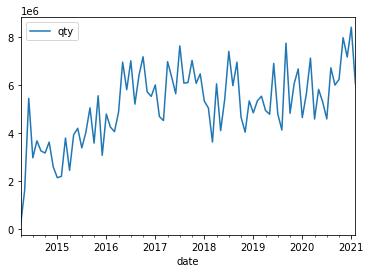

In [ ]:
# Monthly plot
df_clean.resample('M').sum().plot()

### Time series Decomposition

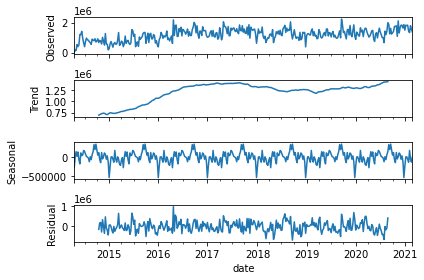

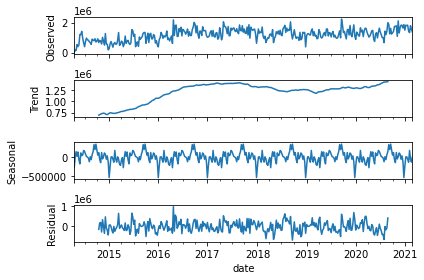

In [ ]:
result = seasonal_decompose(df_clean, model='additive', freq=52)
result.plot()

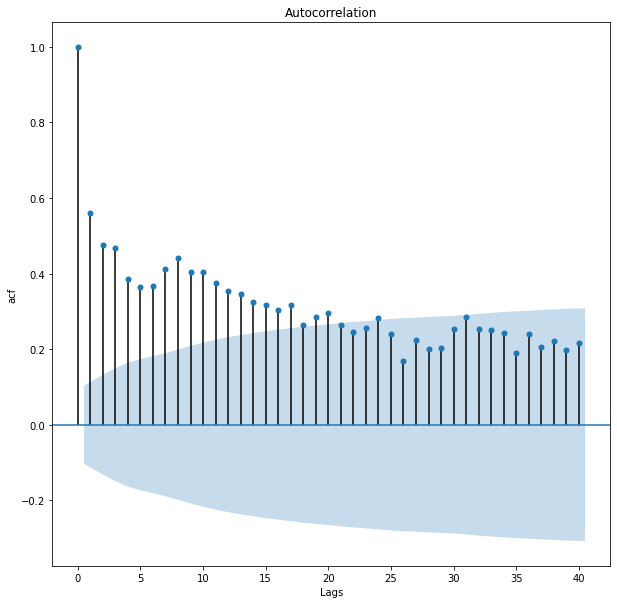

In [ ]:
# Autocorrelation
plot_autocorrelation(df_clean, col='qty', plot_type="acf")

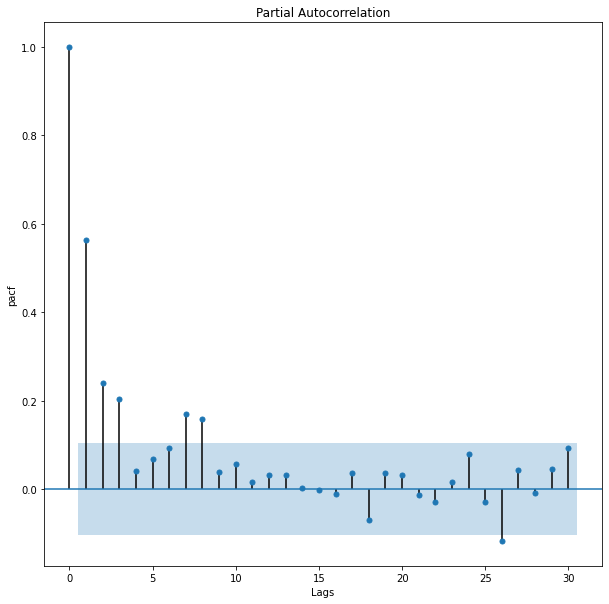

In [ ]:
# Partial autocorrelation
plot_autocorrelation(df_clean, col='qty', plot_type="pacf", n_lags=30)

## 4. Data Modelling

### Prophet forecasting

In [ ]:
df_clean.head()
df_clean = df_clean.reset_index()

In [ ]:
df_clean.dtypes

date    datetime64[ns]
qty              int64
dtype: object

In [ ]:
df2 = df_clean.rename(columns={"date": "ds", "qty": "y"})

In [ ]:
df2.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [ ]:
df2.head()

,ds,y
0,2014-04-20,5000
1,2014-04-27,160000
2,2014-05-04,151200
3,2014-05-11,538150
4,2014-05-18,397511


In [ ]:
# Train/test split :

split_date = '2021-01-01'

train = df2[df2["ds"] <= split_date]
test = df2[df2["ds"] > split_date]

In [ ]:
print(train.shape, test.shape)

(350, 2) (9, 2)


In [ ]:
model = Prophet(daily_seasonality=False,
                yearly_seasonality = True,
                weekly_seasonality= False,
                changepoint_prior_scale = 0.5,
                seasonality_prior_scale = 1,
                n_changepoints = 200
                )

# model = Prophet()
model.fit(train)

In [ ]:
future = model.make_future_dataframe(periods=55,freq = 'W')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
400,2021-12-19,1.588187e+06,1.240298e+06,1.948906e+06
401,2021-12-26,1.402651e+06,1.052816e+06,1.772885e+06
402,2022-01-02,1.311122e+06,9.232564e+05,1.657133e+06
403,2022-01-09,1.374056e+06,1.007752e+06,1.750414e+06
404,2022-01-16,1.523190e+06,1.175071e+06,1.879506e+06


In [ ]:
forecast_lite = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
forecast_lite.to_csv('forecast_fish.csv',sep = ';')

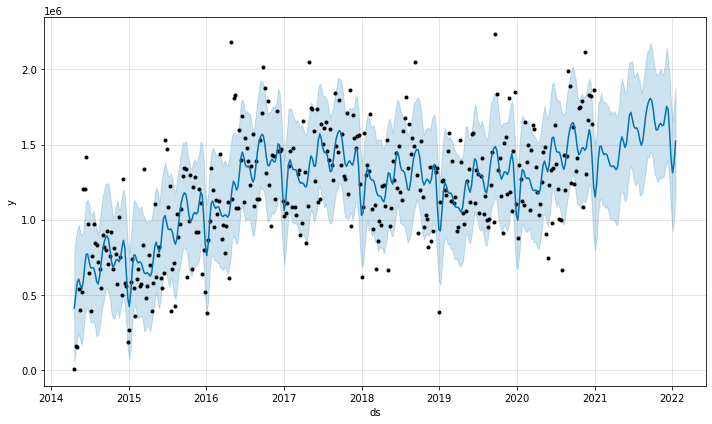

In [ ]:
model.plot(forecast)
plt.show()

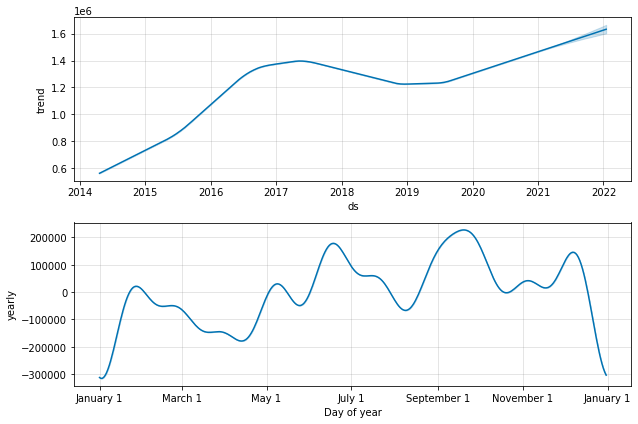

In [ ]:
model.plot_components(forecast)
plt.show()

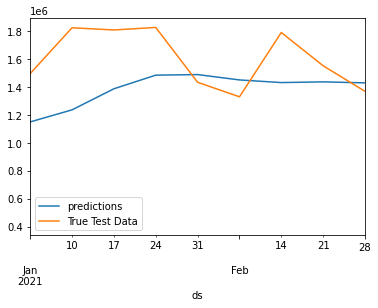

In [ ]:
ax=forecast.plot(x='ds',
                 y='yhat',
                 legend=True,label='predictions')
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2021-01-01','2021-02-28'))

In [ ]:
# Initial training period.
initial= 600
initial= str(initial)+' days'
#Period length that we perform the cross validation for.
period= 365
period=str(period)+' days'
#Horizon of prediction essentially for each fold.
horizon = 200
horizon=str(horizon)+' days'

cv = cross_validation(model,initial=initial,period=period,horizon=horizon) # Performance Metrics


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-06-11 00:00:00 and 2020-06-10 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 88.
INFO:fbprophet:n_changepoints greater than number of observations. Using 131.
INFO:fbprophet:n_changepoints greater than number of observations. Using 172.


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_forecast = model.predict(test)
mape = mean_absolute_percentage_error(test['y'],test_forecast['yhat'])
print("MAPE",round(mape,3))

MAPE 15.803


In [ ]:
from fbprophet.diagnostics import performance_metrics
performance_metrics(cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,20 days,1.385205e+11,372183.399073,305435.911174,0.254573,0.162581,0.642857
1,21 days,1.288703e+11,358985.118045,288755.013632,0.242051,0.141978,0.714286
2,22 days,1.065621e+11,326438.517668,257536.219335,0.206295,0.127204,0.785714
3,25 days,9.620429e+10,310168.158862,233739.315814,0.184188,0.110317,0.857143
4,26 days,9.794336e+10,312959.042222,236819.323472,0.189553,0.110317,0.857143
...,...,...,...,...,...,...,...
124,194 days,1.184548e+11,344172.694674,285307.295260,0.183876,0.186790,0.714286
125,195 days,1.367525e+11,369800.609374,310181.574551,0.203264,0.198961,0.642857
126,196 days,1.255319e+11,354304.862254,285765.280951,0.187053,0.186790,0.714286
127,197 days,1.199027e+11,346269.639596,274926.151019,0.185591,0.176556,0.714286


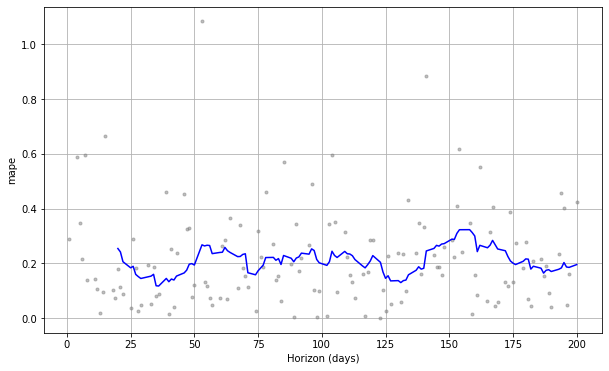

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv, metric='mape')

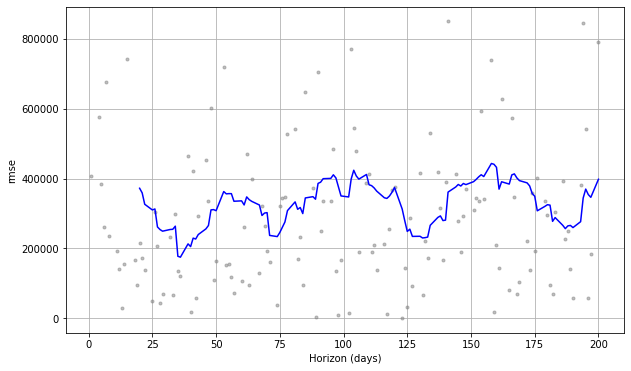

In [ ]:
plot_cross_validation_metric(cv,'rmse');

### Model parameter tuning

In [ ]:
from tqdm import tqdm

In [ ]:
# Python
import itertools

param_grid = {
    'changepoint_prior_scale':  [0.1, 0.5, 0.9],
    'seasonality_prior_scale': [0.1, 0.5, 0.9],
    'n_changepoints' : [50,200,300]
    }

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='300 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
tuning_results